In [287]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('US-Covid.csv')
data.head()

,countyFIPS,County Name,State,StateFIPS,population,2020-06-01_cases,2020-06-02_cases,2020-06-03_cases,2020-06-04_cases,2020-06-05_cases,...,2020-12-25_deaths,2020-12-26_deaths,2020-12-27_deaths,2020-12-28_deaths,2020-12-29_deaths,2020-12-30_deaths,2020-12-31_deaths,2021-01-01_deaths,2021-01-02_deaths,2021-01-03_deaths
0,1001,Autauga County,AL,1,55869,233,238,239,241,248,...,46,46,47,47,47,48,48,50,50,50
1,1003,Baldwin County,AL,1,223234,292,292,292,293,296,...,151,151,152,152,156,160,161,169,169,169
2,1005,Barbour County,AL,1,24686,172,175,177,177,183,...,32,32,32,32,32,32,32,33,33,33
3,1007,Bibb County,AL,1,22394,76,76,76,76,76,...,42,42,42,42,42,46,46,46,46,46
4,1009,Blount County,AL,1,57826,63,63,63,63,64,...,58,58,58,58,58,63,63,63,63,63


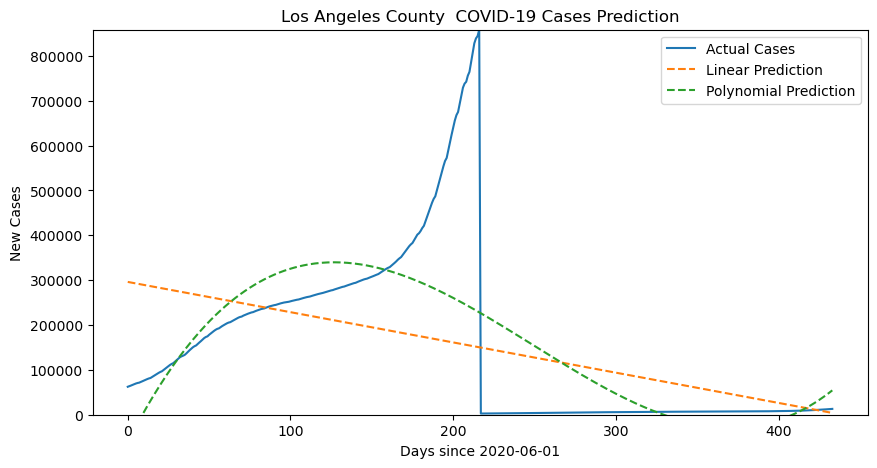

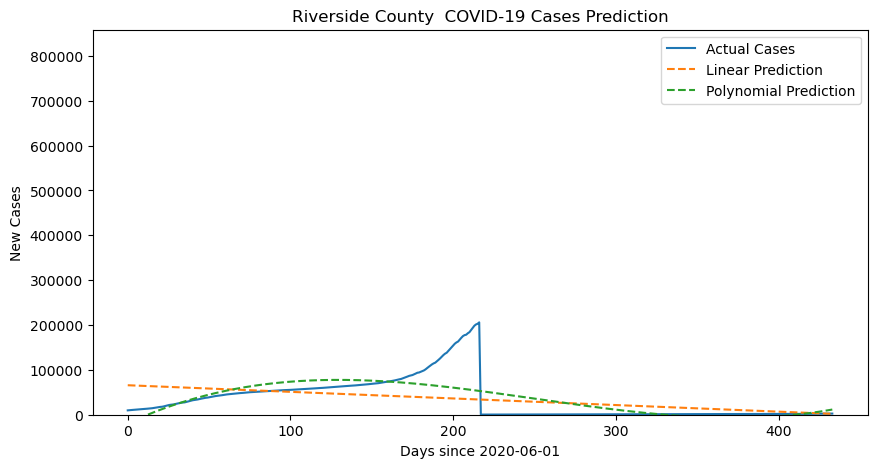

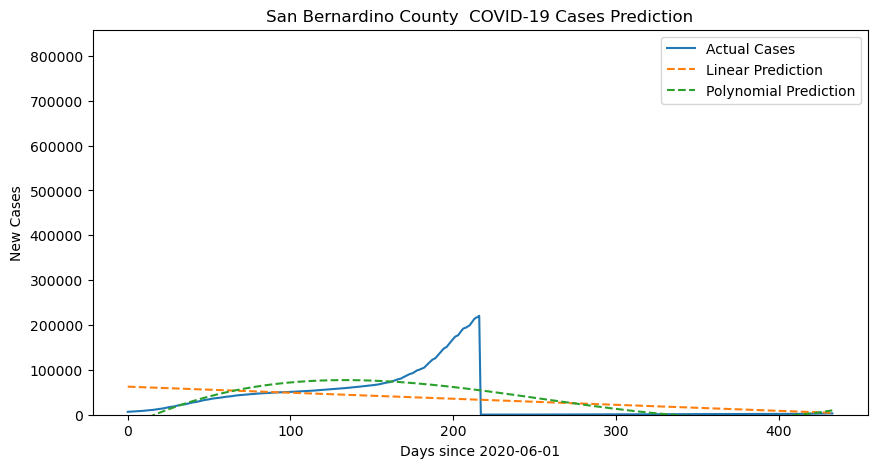

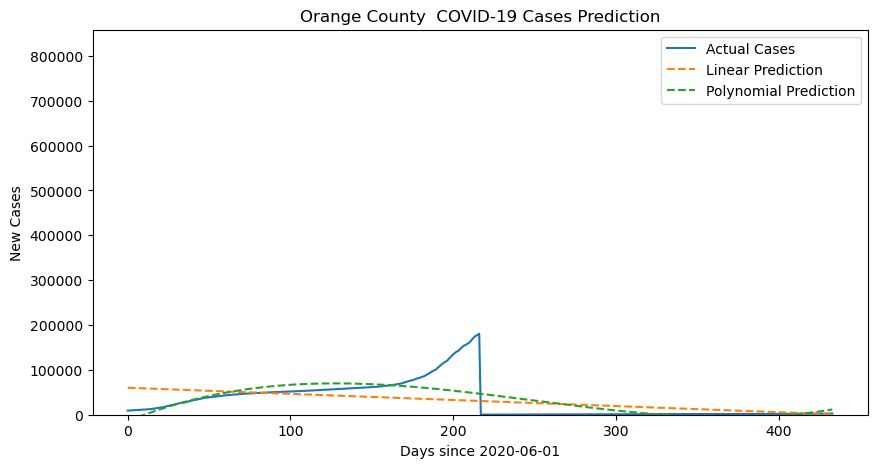

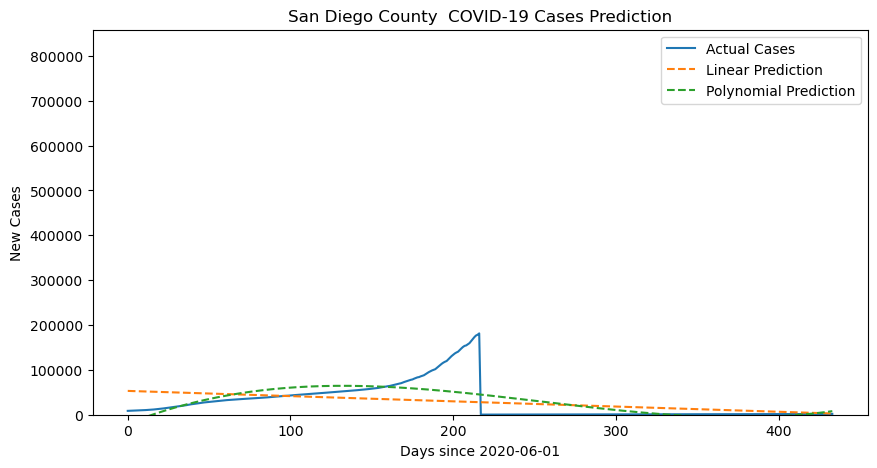

In [288]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
enrichment_data = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Filter for California and find the top 5 counties by total cases
covid_data_ca = covid_data[covid_data['State'] == 'CA']
# Use .loc to avoid SettingWithCopyWarning
covid_data_ca = covid_data_ca.copy()  # Create a copy of the DataFrame to work on
covid_data_ca['total_cases'] = covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1)

top_counties = covid_data_ca.nlargest(5, 'total_cases')['County Name']

# Initialize a variable to hold the maximum y-value
max_y_value = 0

# Perform analysis for each top county
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_cases', 
                                         value_name='cases')
    
    # Extract date from the 'date_cases' column
    county_data_long['date'] = county_data_long['date_cases'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or cases are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'cases'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_cases = county_data_long['cases'].values
    days_since_start = np.arange(len(county_cases)).reshape(-1, 1)
    X = days_since_start
    y_cases = county_cases
    
    # Update the maximum y-value if the current county's cases exceed it
    max_y_value = max(max_y_value, np.max(y_cases))

# Perform analysis for each top county again to plot with consistent y-axis
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_cases', 
                                         value_name='cases')
    
    # Extract date from the 'date_cases' column
    county_data_long['date'] = county_data_long['date_cases'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or cases are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'cases'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_cases = county_data_long['cases'].values
    days_since_start = np.arange(len(county_cases)).reshape(-1, 1)
    X = days_since_start
    y_cases = county_cases
    
    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X, y_cases)
    y_cases_pred_linear = linear_model.predict(X)
    
    # Polynomial Regression (Degree 3)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y_cases)
    y_cases_pred_poly = poly_model.predict(X_poly)
    
    # RMSE Calculation
    rmse_linear = np.sqrt(np.mean((y_cases - y_cases_pred_linear) ** 2))
    rmse_poly = np.sqrt(np.mean((y_cases - y_cases_pred_poly) ** 2))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(X, y_cases, label="Actual Cases")
    plt.plot(X, y_cases_pred_linear, label="Linear Prediction", linestyle="--")
    plt.plot(X, y_cases_pred_poly, label="Polynomial Prediction", linestyle="--")
    plt.title(f"{county} COVID-19 Cases Prediction")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Cases")
    plt.ylim(0, max_y_value)  # Set y-axis limits to the maximum value found
    plt.legend()
    plt.show()


# First Part Complete Above

In [290]:
import pandas as pd
import numpy as np
from scipy import stats

# Load enrichment data and COVID data for California
enrichment_data = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv(r"C:\Users\bluev\Downloads\Group7ClassProject\Stage II\Hamza Ahmed\filtered_super_dates_June2020_Jan2021_and_6_states.csv")

# Step 1: Reshape enrichment data to make rows into columns
# Filter rows that are of interest and pivot them into a single-row DataFrame
columns_of_interest = ["Civilian labor force", "Employed", "With health insurance coverage"]
enrichment_data_filtered = enrichment_data[enrichment_data['Label (Grouping)'].isin(columns_of_interest)]
enrichment_data_pivoted = enrichment_data_filtered.pivot_table(
    index=None,
    columns="Label (Grouping)",
    values="California!!Estimate"  # Adjust if necessary to use the correct state's column
).reset_index(drop=True)

# Step 2: Add California average cases per 100k to the pivoted DataFrame
covid_data_ca = covid_data[covid_data['State'] == 'CA'].copy()
covid_data_ca['total_cases'] = covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1)
covid_data_ca['cases_per_100k'] = (covid_data_ca['total_cases'] / covid_data_ca['population']) * 100000
california_avg_cases_per_100k = covid_data_ca['cases_per_100k'].mean()
enrichment_data_pivoted['cases_per_100k'] = california_avg_cases_per_100k

# Step 3: Define T-test function
def perform_t_test(data, enrichment_column, outcome_column='cases_per_100k'):
    if enrichment_column not in data.columns:
        print(f"{enrichment_column} column not found in enrichment data.")
        return
    
    median_value = data[enrichment_column].median()
    high_group = data[data[enrichment_column] > median_value][outcome_column]
    low_group = data[data[enrichment_column] <= median_value][outcome_column]
    
    t_stat, p_value = stats.ttest_ind(high_group, low_group, equal_var=False)
    print(f"T-test for {enrichment_column}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Step 4: Perform T-tests for selected variables
for column in columns_of_interest:
    perform_t_test(enrichment_data_pivoted, column)


Civilian labor force column not found in enrichment data.
Employed column not found in enrichment data.
With health insurance coverage column not found in enrichment data.


# Next Part

# Here you see I'm getting some weird values in the results

In [293]:
import pandas as pd

# Load your enrichment dataset
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")

# Check unique values in the 'Label (Grouping)' column
print(enrichment_data['Label (Grouping)'].unique())

# Attempt to extract values for the hypotheses
try:
    civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'Civilian labor force', 'California!!Estimate'].values[0]
    employed = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'Employed', 'California!!Estimate'].values[0]
    health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'With health insurance coverage', 'California!!Estimate'].values[0]
except IndexError as e:
    print("IndexError: Could not find one of the labels in the enrichment dataset.")
    print(e)

# Print the extracted values to confirm they were obtained correctly
print(f'Civilian Labor Force: {civilian_labor_force}')
print(f'Employed: {employed}')
print(f'Health Insurance Coverage: {health_insurance_coverage}')


['EMPLOYMENT STATUS' '\xa0\xa0\xa0\xa0Population 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Not in labor force'
 '\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployment Rate'
 '\xa0\xa0\xa0\xa0Females 16 years and over'
 '\xa0\xa0\xa0\xa0Own children of the householder under 6 years'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0All parents in family in labor force'
 '\xa0\xa0\xa0\xa0Own children of the householder 6 to 17 years'
 'COMMUTING TO WORK' '\xa0\xa0\xa0\xa0Workers 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, truck, or van -- drove alone'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, truck, or van -- carpoole

In [294]:
import pandas as pd

# Load the datasets
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")
covid_data = pd.read_csv('US-Covid.csv')
print(enrichment_data.columns)
print(enrichment_data['Label (Grouping)'].unique())
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()
filtered_data = enrichment_data[enrichment_data['Label (Grouping)'] == 'Civilian labor force']
print(filtered_data)

# Clean the column names by stripping whitespace
enrichment_data.columns = enrichment_data.columns.str.strip()

# Extract relevant values from the enrichment dataset
civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Civilian labor force', 'California!!Estimate'].values[0]
employed = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Employed', 'California!!Estimate'].values[0]
health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'With health insurance coverage', 'California!!Estimate'].values[0]

print(f"Civilian Labor Force: {civilian_labor_force}")
print(f"Employed: {employed}")
print(f"Health Insurance Coverage: {health_insurance_coverage}")


Index(['Label (Grouping)', 'California!!Estimate', 'California!!Percent'], dtype='object')
['EMPLOYMENT STATUS' '\xa0\xa0\xa0\xa0Population 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Not in labor force'
 '\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployment Rate'
 '\xa0\xa0\xa0\xa0Females 16 years and over'
 '\xa0\xa0\xa0\xa0Own children of the householder under 6 years'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0All parents in family in labor force'
 '\xa0\xa0\xa0\xa0Own children of the householder 6 to 17 years'
 'COMMUTING TO WORK' '\xa0\xa0\xa0\xa0Workers 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, tru

In [295]:
import pandas as pd

# Load the datasets
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Clean the column names by stripping whitespace
enrichment_data.columns = enrichment_data.columns.str.strip()

# Clean 'Label (Grouping)' values by stripping whitespace and removing any non-breaking spaces
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().replace(r'\xa0', '', regex=True)

# Check the unique values again after cleaning
print(enrichment_data['Label (Grouping)'].unique())

# Extract relevant values from the enrichment dataset
civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Civilian labor force', 'California!!Estimate'].values[0]
employed = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Employed', 'California!!Estimate'].values[0]
health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'With health insurance coverage', 'California!!Estimate'].values[0]

print(f"Civilian Labor Force: {civilian_labor_force}")
print(f"Employed: {employed}")
print(f"Health Insurance Coverage: {health_insurance_coverage}")


['EMPLOYMENT STATUS' 'Population 16 years and over' 'In labor force'
 'Civilian labor force' 'Employed' 'Unemployed' 'Armed Forces'
 'Not in labor force' 'Unemployment Rate' 'Females 16 years and over'
 'Own children of the householder under 6 years'
 'All parents in family in labor force'
 'Own children of the householder 6 to 17 years' 'COMMUTING TO WORK'
 'Workers 16 years and over' 'Car, truck, or van -- drove alone'
 'Car, truck, or van -- carpooled'
 'Public transportation (excluding taxicab)' 'Walked' 'Other means'
 'Worked from home' 'Mean travel time to work (minutes)' 'OCCUPATION'
 'Civilian employed population 16 years and over'
 'Management, business, science, and arts occupations'
 'Service occupations' 'Sales and office occupations'
 'Natural resources, construction, and maintenance occupations'
 'Production, transportation, and material moving occupations' 'INDUSTRY'
 'Agriculture, forestry, fishing and hunting, and mining' 'Construction'
 'Manufacturing' 'Wholesale trad

In [296]:
# Check specific values for labels of interest
relevant_labels = [
    'civilian labor force',
    'employed',
    'with health insurance coverage'
]

for label in relevant_labels:
    print(f"Values for '{label}':", enrichment_data.loc[enrichment_data['Label (Grouping)'] == label])


Values for 'civilian labor force': Empty DataFrame
Columns: [Label (Grouping), California!!Estimate, California!!Percent]
Index: []
Values for 'employed': Empty DataFrame
Columns: [Label (Grouping), California!!Estimate, California!!Percent]
Index: []
Values for 'with health insurance coverage': Empty DataFrame
Columns: [Label (Grouping), California!!Estimate, California!!Percent]
Index: []


# First Attempt

In [298]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# Load your datasets
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Normalize strings in the 'Label (Grouping)' column
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().str.lower()

# Function to get values safely and ensure they are numeric
def get_value(label):
    try:
        value = enrichment_data.loc[
            enrichment_data['Label (Grouping)'] == label.lower(),
            'California!!Estimate'
        ].values[0]
        return pd.to_numeric(value, errors='coerce')  # Convert to numeric
    except IndexError:
        print(f"Warning: No data found for '{label}'")
        return None

# Extract relevant values from the enrichment dataset
civilian_labor_force = get_value('Civilian labor force')
employed = get_value('Employed')
health_insurance_coverage = get_value('With health insurance coverage')

# Check if any of the values are None and handle accordingly
if civilian_labor_force is None or employed is None or health_insurance_coverage is None:
    print("One or more required values are missing. Please check the enrichment dataset.")
else:
    # Get the current date and end date
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = '2021-01-03'

    # Generate a list of relevant date columns within the date range
    date_columns = [date for date in covid_data.columns if start_date <= date <= end_date]

    # Check if date_columns is empty
    if not date_columns:
        print("No date columns found within the specified date range.")
    else:
        # Filter COVID-19 data for relevant dates
        covid_data_filtered = covid_data[['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'] + date_columns]

        # Hypothesis Testing Function
        def perform_hypothesis_test(covid_data, employment_value, date_columns):
            # Get average cases per 10,000 population for the specified date range
            covid_cases_per_10k = covid_data[date_columns].sum(axis=1) / (covid_data['population'] / 10000)

            # Check for NaN values in covid_cases_per_10k
            if covid_cases_per_10k.isnull().all():
                print("All COVID cases per 10,000 are NaN.")
                return np.nan, np.nan, covid_cases_per_10k

            # Create high and low groups based on employment value
            mean_cases = covid_cases_per_10k.mean()
            print(f"Mean cases for employment value {employment_value}: {mean_cases}")

            # Ensure employment_value is a float
            employment_value = float(employment_value)

            # Separate cases into high and low based on mean cases
            if employment_value > mean_cases:
                high_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]
                low_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
            else:
                high_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
                low_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]

            # Print the groups
            print(f"High cases for employment value {employment_value}: {high_cases}")
            print(f"Low cases for employment value {employment_value}: {low_cases}")

            # Check if either group is empty
            if high_cases.empty or low_cases.empty:
                print("One of the groups is empty. High cases or low cases may not have enough data.")
                return np.nan, np.nan, covid_cases_per_10k

            # Perform two-sample t-test
            t_stat, p_value = stats.ttest_ind(high_cases, low_cases, equal_var=False)  # Welch's t-test
            return t_stat, p_value, covid_cases_per_10k

        # Perform hypothesis tests
        t_stat_civilian, p_value_civilian, cases_civilian = perform_hypothesis_test(covid_data_filtered, civilian_labor_force, date_columns)
        print(f'Civilian Labor Force - T-statistic: {t_stat_civilian}, P-value: {p_value_civilian}')

        t_stat_employed, p_value_employed, cases_employed = perform_hypothesis_test(covid_data_filtered, employed, date_columns)
        print(f'Employed - T-statistic: {t_stat_employed}, P-value: {p_value_employed}')

        t_stat_health_insurance, p_value_health_insurance, cases_health_insurance = perform_hypothesis_test(covid_data_filtered, health_insurance_coverage, date_columns)
        print(f'Health Insurance Coverage - T-statistic: {t_stat_health_insurance}, P-value: {p_value_health_insurance}')

        # Function to plot hypothesis results
        def plot_hypothesis_results(cases_per_10k, employment_value, label):
            plt.figure(figsize=(12, 6))  # Increase figure size for better readability
            plt.title(f'COVID-19 Cases Based on {label}')

            # Drop NaN values to avoid plotting issues
            cases_per_10k = cases_per_10k.dropna()

            # Create histogram with more bins and adjusted range
            plt.hist(cases_per_10k, bins=50, alpha=0.7, color='blue', label='COVID-19 Cases per 10,000')

            # Add a vertical line for employment value
            plt.axvline(employment_value, color='red', linestyle='dashed', linewidth=2, label='Employment Threshold')

            # Set x-axis limits (adjust these values based on your data range)
            plt.xlim(0, cases_per_10k.max() + 5)  # Add a little padding

            # Adding grid lines for better readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Set labels and legend
            plt.xlabel('Cases per 10,000')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
            plt.show()

        


Mean cases for employment value nan: 691.8184881658256
High cases for employment value nan: 1       637.582089
2       633.152394
9       557.336998
11      409.087298
18      498.921504
           ...    
3130    476.550681
3132    606.960951
3134    544.501370
3136    615.400264
3141    691.497041
Length: 1661, dtype: float64
Low cases for employment value nan: 0        779.502049
3        860.944896
4        831.632830
5        912.780913
6        818.078980
           ...     
3135     849.598163
3137     717.001630
3138     921.837709
3139     779.689509
3140    1027.546445
Length: 1481, dtype: float64
Civilian Labor Force - T-statistic: -63.53384696017083, P-value: 0.0
Mean cases for employment value nan: 691.8184881658256
High cases for employment value nan: 1       637.582089
2       633.152394
9       557.336998
11      409.087298
18      498.921504
           ...    
3130    476.550681
3132    606.960951
3134    544.501370
3136    615.400264
3141    691.497041
Length: 1661, d

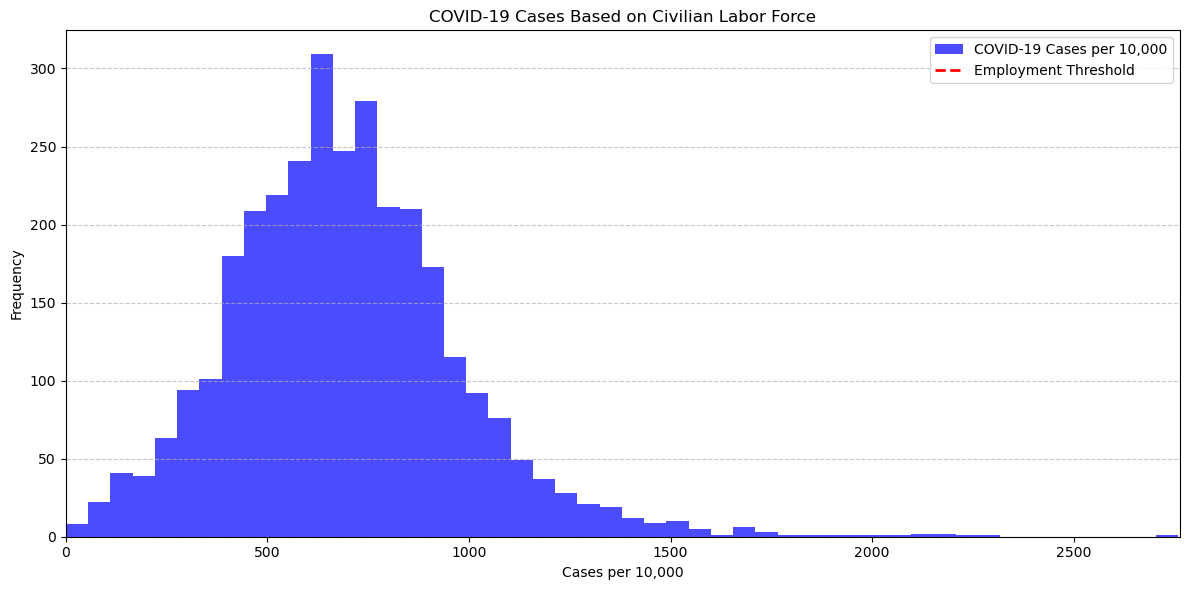

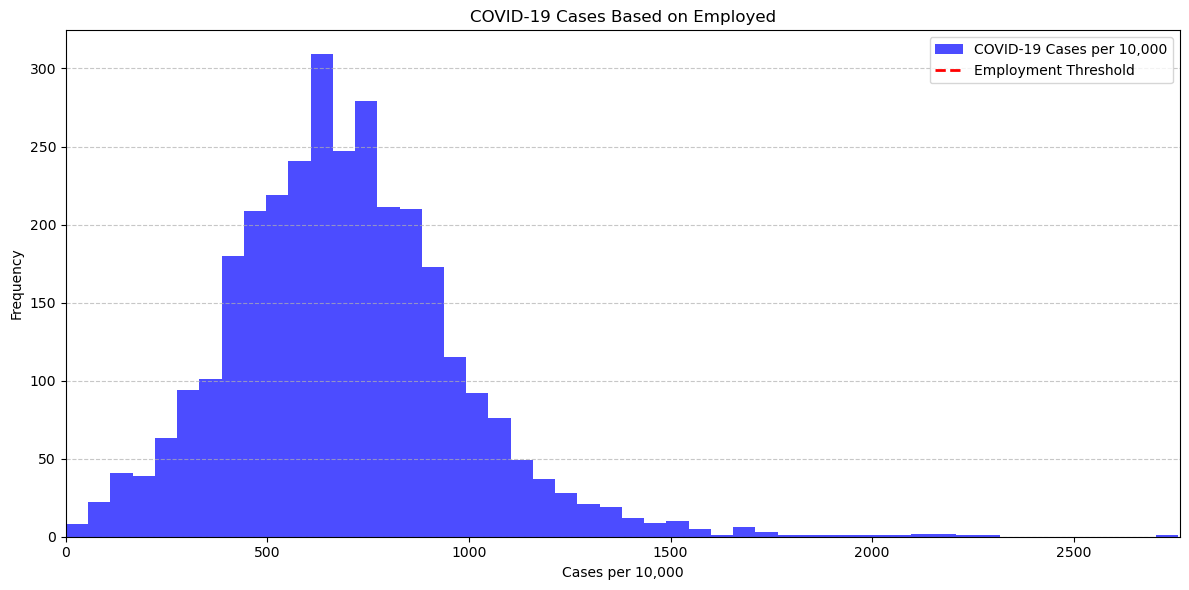

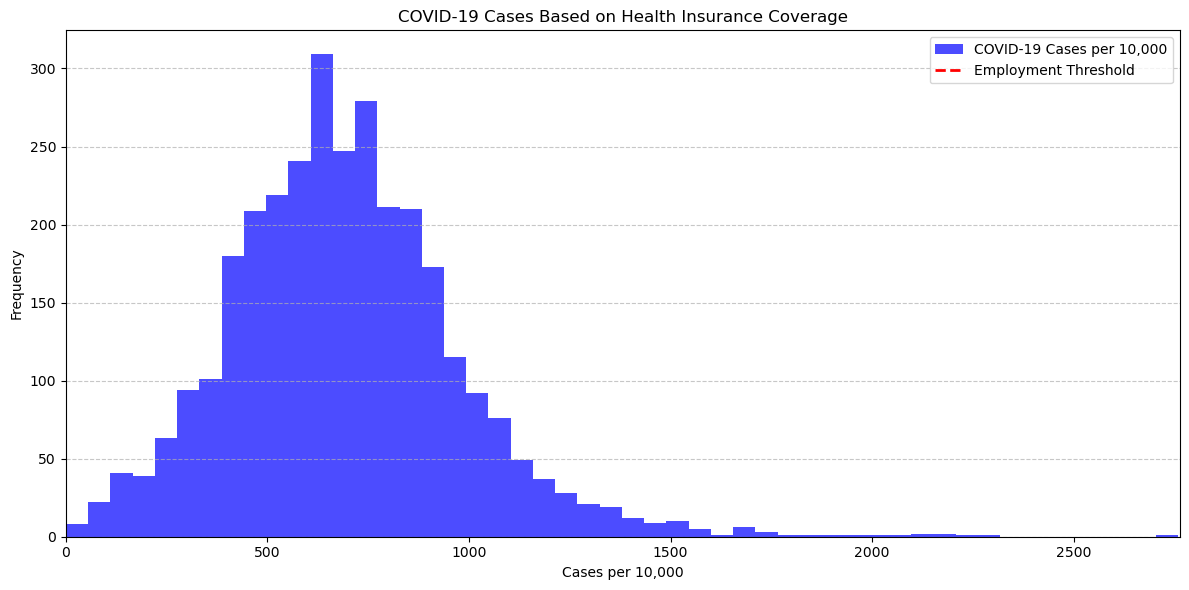

In [299]:
# Plot results for each hypothesis with appropriate labels
plot_hypothesis_results(cases_civilian, civilian_labor_force, 'Civilian Labor Force')
plot_hypothesis_results(cases_employed, employed, 'Employed')
plot_hypothesis_results(cases_health_insurance, health_insurance_coverage, 'Health Insurance Coverage')

# Attempting to graph

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# Load datasets
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Normalize strings in 'Label (Grouping)' column
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().str.lower()

# Function to get values safely and ensure they are numeric
def get_value(label):
    try:
        value = enrichment_data.loc[
            enrichment_data['Label (Grouping)'] == label.lower(),
            'California!!Estimate'
        ].values[0]
        return pd.to_numeric(value, errors='coerce')
    except IndexError:
        print(f"Warning: No data found for '{label}'")
        return None

# Extract values
civilian_labor_force = get_value('Civilian labor force')
employed = get_value('Employed')
health_insurance_coverage = get_value('With health insurance coverage')

# Define start and end dates for COVID data filtering
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = '2021-01-03'
date_columns = [date for date in covid_data.columns if start_date <= date <= end_date]

# Filter COVID-19 data for relevant dates
covid_data_filtered = covid_data[['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'] + date_columns]

# Hypothesis Testing Function
def perform_hypothesis_test(covid_data, employment_value, date_columns):
    covid_cases_per_10k = covid_data[date_columns].sum(axis=1) / (covid_data['population'] / 10000)

    if covid_cases_per_10k.isnull().all():
        print("All COVID cases per 10,000 are NaN.")
        return np.nan, np.nan, covid_cases_per_10k

    mean_cases = covid_cases_per_10k.mean()
    employment_value = float(employment_value)

    if employment_value > mean_cases:
        high_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]
        low_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
    else:
        high_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
        low_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]

    if high_cases.empty or low_cases.empty:
        print("One of the groups is empty. High cases or low cases may not have enough data.")
        return np.nan, np.nan, covid_cases_per_10k

    t_stat, p_value = stats.ttest_ind(high_cases, low_cases, equal_var=False)  # Welch's t-test
    return t_stat, p_value, covid_cases_per_10k

# Perform hypothesis tests and store results for checking
t_stat_civilian, p_value_civilian, cases_civilian = perform_hypothesis_test(covid_data_filtered, civilian_labor_force, date_columns)
t_stat_employed, p_value_employed, cases_employed = perform_hypothesis_test(covid_data_filtered, employed, date_columns)
t_stat_health_insurance, p_value_health_insurance, cases_health_insurance = perform_hypothesis_test(covid_data_filtered, health_insurance_coverage, date_columns)

# Plotting Function
def plot_hypothesis_results(cases_per_10k, employment_value, label):
    plt.figure(figsize=(12, 6))
    plt.title(f'COVID-19 Cases Based on {label}')

    cases_per_10k = cases_per_10k.dropna()
    bins = int(np.sqrt(len(cases_per_10k)))
    plt.hist(cases_per_10k, bins=bins, alpha=0.7, color='blue', label='COVID-19 Cases per 10,000')

    plt.axvline(employment_value, color='red', linestyle='dashed', linewidth=2, label='Employment Threshold')
    plt.xlim(0, cases_per_10k.max() + 5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Cases per 10,000')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results for each hypothesis with appropriate labels
plot_hypothesis_results(cases_civilian, civilian_labor_force, 'Civilian Labor Force')
plot_hypothesis_results(cases_employed, employed, 'Employed')
plot_hypothesis_results(cases_health_insurance, health_insurance_coverage, 'Health Insurance Coverage')

In [301]:
enrichment_data.head()

,Label (Grouping),California!!Estimate,California!!Percent
0,employment status,NaN,NaN
1,population 16 years and over,"31,403,964","31,403,964"
2,in labor force,"20,016,955",63.7%
3,civilian labor force,"19,875,973",63.3%
4,employed,"18,646,894",59.4%
